## Lecture 10: Structural equation modeling

In this lecture we will focus on the estimation of parameters for SEM models.  We will use the *lavaan* R package for SEM analysis - there are Python-based packages, but they are not as widely accepted as lavaan. This will also highlight the utility of the R-to-Python bridge provided by Jupyter and the rpy2 package.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML
import rpy2
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

import seaborn as sns

%load_ext rpy2.ipython

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Linear regression

We will start by showing how one can estimate a simple linear regression model using SEM.  We will use simulated data so that we know the ground truth.

First, let's generate some data.

,x,Y
x,1.000000,0.371985
Y,0.371985,1.000000


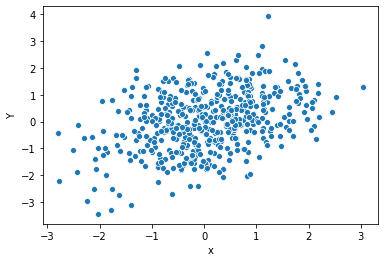

In [2]:
npts = 500
noise_sd = 1
rng = np.random.RandomState(1)
simdataDf = pd.DataFrame({'x': rng.randn(npts)})
beta = np.array([0.5])
simdataDf['Y'] = simdataDf.dot(beta) + np.random.randn(npts)*noise_sd

sns.scatterplot(x='x', y='Y', data=simdataDf)
simdataDf.corr()

In [3]:
# estimate linear regression model

X = sm.add_constant(simdataDf[['x']])
y = simdataDf['Y']
model = sm.OLS(y, X)
ols_results = model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     79.98
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           7.45e-18
Time:                        18:08:21   Log-Likelihood:                -712.13
No. Observations:                 500   AIC:                             1428.
Df Residuals:                     498   BIC:                             1437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.045      0.214      0.8

Now let's build a structural model for this analysis using lavaan.

In [4]:
%%R -i simdataDf -o results

library(lavaan)
myModel <- ' # regressions
             Y ~ x
    
             # variances and covariances 
             Y ~~ Y 

             # intercepts 
             Y~ 1 
           '

fit <- lavaan(myModel, data=simdataDf)
summary(fit, standardized=TRUE)

results = list(fitted = fitted(fit)$cov,
              resid = resid(fit)$cov,
              coefs = coef(fit))

R[write to console]: This is lavaan 0.6-5

R[write to console]: lavaan is BETA software! Please report any bugs.



lavaan 0.6-5 ended normally after 11 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          3
                                                      
  Number of observations                           500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  Y ~                                                                   
    x                 0.408    0.045    8.961    0.000    0.408    0.372

Intercepts:

R[write to console]: Registered S3 methods overwritten by 'huge':
  method    from   
  plot.sim  BDgraph
  print.sim BDgraph



$cov
  Y     x    
Y 1.173      
x 0.398 0.977

$mean
    Y     x 
0.031 0.053 



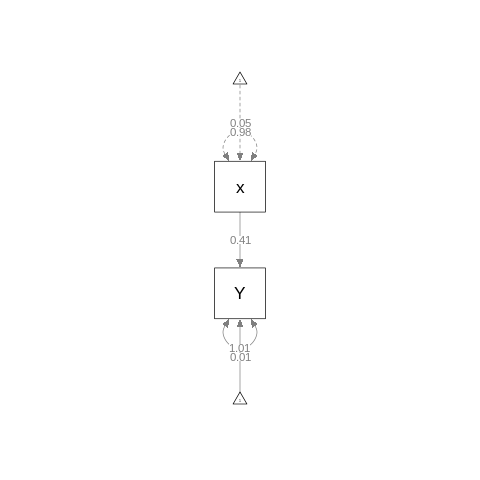

In [5]:
%%R
library(semPlot)

semPaths(fit, "model", "est", rotation=1, sizeMan =10, sizeMan2 = 10, 
        edge.label.cex = 1)

fitted(fit)

As you can see, the estimated parameters from SEM are the same as the regression model. However, the standard errors are very slightly different (not noticable to the third decimal place in this case) - this is because the OLS regression estimates using the unbiased estimator for the variance (with N-1 in the denominator), whereas SEM uses maximum likelihood which is a biased estimator of the variance (with N in the denominator).  These differences are minor unless the sample size is very small.



## Estimating SEM parameters

We saw in the earlier session on regression how those parameters are estimated using least squares.  SEM models are estimated in a different way.  Most importantly, the main difference between SEM and regression is the loss function: Whereas in linear regression we used the sum of squared errors between the predicted and estimated values for the data points, in SEM we use the sum of squared differences between the observed covariance and the covariance predicted by the model. For this reason, these models are often referred to as "covariance structure models".

The observed covariance between all measured variables serves as our estimate of the population covariance, which we simply plug into the loss function.  We compare this to the covariance matrix that is implied by any specific set of parameter values. 

Let's see how this works for the simple regression example, where we only have a single parameter.  The implied covariance matrix here is:



| $\sigma^2(x)$  |                | 
| ------------- | -------------  |
| $cov(x*\beta_1,x)$    |  $\sigma^2(y)$  |  


In [6]:
S = simdataDf.cov().values
print('observed covariance')
print(S)

observed covariance
[[0.9789087  0.39900806]
 [0.39900806 1.17536105]]


Let's create a function to generate the implied covariance from this dataset, given a specific value of $\beta_1$:

In [7]:
def get_implied_cov(dataDf, beta):
    # get observed cov
    observed = np.cov(dataDf.values.T)
    # get diagonal from observed
    sigma = np.zeros(observed.shape)
    sigma[np.diag_indices_from(observed)] = np.diag(observed)
    
    # get implied 
    sigma[0, 1] = np.cov(dataDf.x*beta, dataDf.x)[0, 1]
    sigma[1, 0] = sigma[0, 1]
    return(sigma)

sigma = get_implied_cov(simdataDf, ols_results.params.x)
print('model-implied covariance')
print(sigma)

model-implied covariance
[[0.9789087  0.39900806]
 [0.39900806 1.17536105]]


In this case the model-implied differs from the observed covariance matrix at one location (since the variances of x and y remain the same), which is the covariance of predicted values (using $\beta_1$) with the observed values.

## Loss function

Why are we worried about covariances?  Because whereas the squared error loss for ordinary least squares compares the predicted and observed *data*, the loss function for structural equation modeling compares the predicted and observed *covariances*.  Here is the loss function that is used for maximum likelihood estimation (rearranged from Bollen, 1989):

$$
F_{ML}(\theta) = log |\Sigma| - log|\textbf{S}| + tr(\textbf{S}\Sigma^{-1}) - (p + q)
$$

where:

- $log |\Sigma|$ is the log determinant of the implied covariance matrix 
- $log |\textbf{S}|$ is the log determinant of the observed covariance matrix 
- $tr(\textbf{S}\Sigma^{-1})$ is the trace of a matrix obtained by multiplying the observed covariance matrix by the inverse of the implied covariance matrix - basically this is a sum of the ratios of the observed and implied variances; in a simple model like this one, it is simply the number of variables, since the implied and observed variances are identical.
- p is the number of endogenous (dependent) variables
- q is the number of exogenous (independent) variables

Why do we take the determinant of the covariance matrix?  This basically tells us how dispersed our data are. Remember that the determinant of a 2 x 2 matrix:

$$
x = \left[ \begin{array}{cc}
a & b \\
c & d \\
\end{array} \right]
$$

is:

$$
|x| = a*d - b*c
$$

In the case of a covariance matrix, $a$ and $d$ are the variances, and $b$ and $c$ are the covariance, so the determinant is effectively the product of the variances minus the square of the covariance.  Also note that the determinant of a covariance matrix is always positive because the covariance matrices are positive definite. Thus, the determinant will be zero if the covariance is one, whereas the determinant will be maximal when the covariance is zero, and minimal (zero) when the correlation is perfect (either positive or negative):

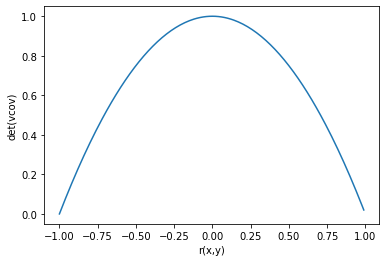

In [8]:
nruns=1000
npts=100
detsimDf = pd.DataFrame({'r': np.arange(-1, 1, 0.01)})

for i in range(detsimDf.shape[0]):
    r = detsimDf.r[i]
    vcov = np.array([[1, r], [r, 1]])
    detsimDf.loc[i, 'det'] = np.linalg.det(vcov)
    
plt.plot(detsimDf.r, detsimDf.det)
plt.xlabel('r(x,y)')
plt.ylabel('det(vcov)')
plt.savefig('det_vs_corr.pdf')


We see that the log determinant is at its minimum when the data are perfectly correlated; in the context of modeling, this means that the better our model, the more of the variance in the data we capture and thus the smaller the difference between the log determinant of the model-implied covariance and the sample covariance.  

Now let's generate a function to compute the loss, given particular implied and observed covariance functions:

In [9]:
def f_ml(cov_est, implied, verbose=False):
    log_det_implied = np.log(np.linalg.det(implied) )
    if verbose:
        print('log(det) for implied:', log_det_implied)
    cov_ratio_trace = np.trace(cov_est.dot(np.linalg.inv(implied)))
    if verbose:
        print('trace of variance ratios:', cov_ratio_trace)
    log_det_observed = np.log(np.linalg.det(cov_est))
    if verbose:
        print('log(det) for observed:', log_det_observed)
    F_ml = log_det_implied + cov_ratio_trace - log_det_observed - cov_est.shape[0]
    return(F_ml)

f_ml(S, sigma, verbose=True)

log(det) for implied: -0.008673779494187284
trace of variance ratios: 2.0
log(det) for observed: -0.008673779494187284


0.0

Now let's try various values for the regression parameter and compute their loss:

Parameter with minimum loss: 0.40760498046060956
OLS estimate of parameter: 0.4076049804606098


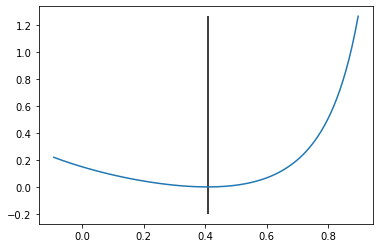

In [10]:
offset = 0.5
params = np.arange(ols_results.params.x - offset, ols_results.params.x + offset, 0.01)
loss_values = np.zeros(params.shape[0])
for i, beta in enumerate(params):
    sigma = get_implied_cov(simdataDf, beta)
    loss_values[i] = f_ml(S, sigma)
    
plt.plot(params, loss_values)
plt.vlines(ols_results.params.x, ymin=np.min(loss_values) - 0.2, ymax=np.max(loss_values))
print('Parameter with minimum loss:', params[np.argmin(loss_values)])
print('OLS estimate of parameter:', ols_results.params.x)

assert np.allclose(params[np.argmin(loss_values)], ols_results.params.x)

## Confirmatory factor analysis

One common use of structural equation modeling is for the estimation of *confirmatory factor analysis* models.  These models include a set of *indicator* variables, which reflect observed measurements.  Each indicator in a standard CFA model has two latent inputs: a single *factor* which is measured by that indicator, and an *error* term that represents the unique sources of variance for that indicator.  There can be multiple factors, which are allowed to correlate with one another.  

For standard CFA models (in which each observed variable is associated with a single latent factor), the identification requirements are simple: for a single factor there must be three indicators, and for two or more factors each factor must be associated with at least two indicators.

As an example, we will use the SRO dataset to fit a CFA model with three factors:

Impulsivity: measured by BIS-11 (nonplanning), Dickman (dysfunctional), and impulsive venturesomeness (impulsiveness) scores
Sensation seeking: measured by UPPS-P (sensation seeking), sensation seeking survey (thrill seeking), and BIS-BAS (fun seeking) scores
Goal-directedness: measured by Grit scale (grit), TIPS (conscientiousness), and UPPS-P (lack of perseverance) scores

Let's set up the model in lavaan:


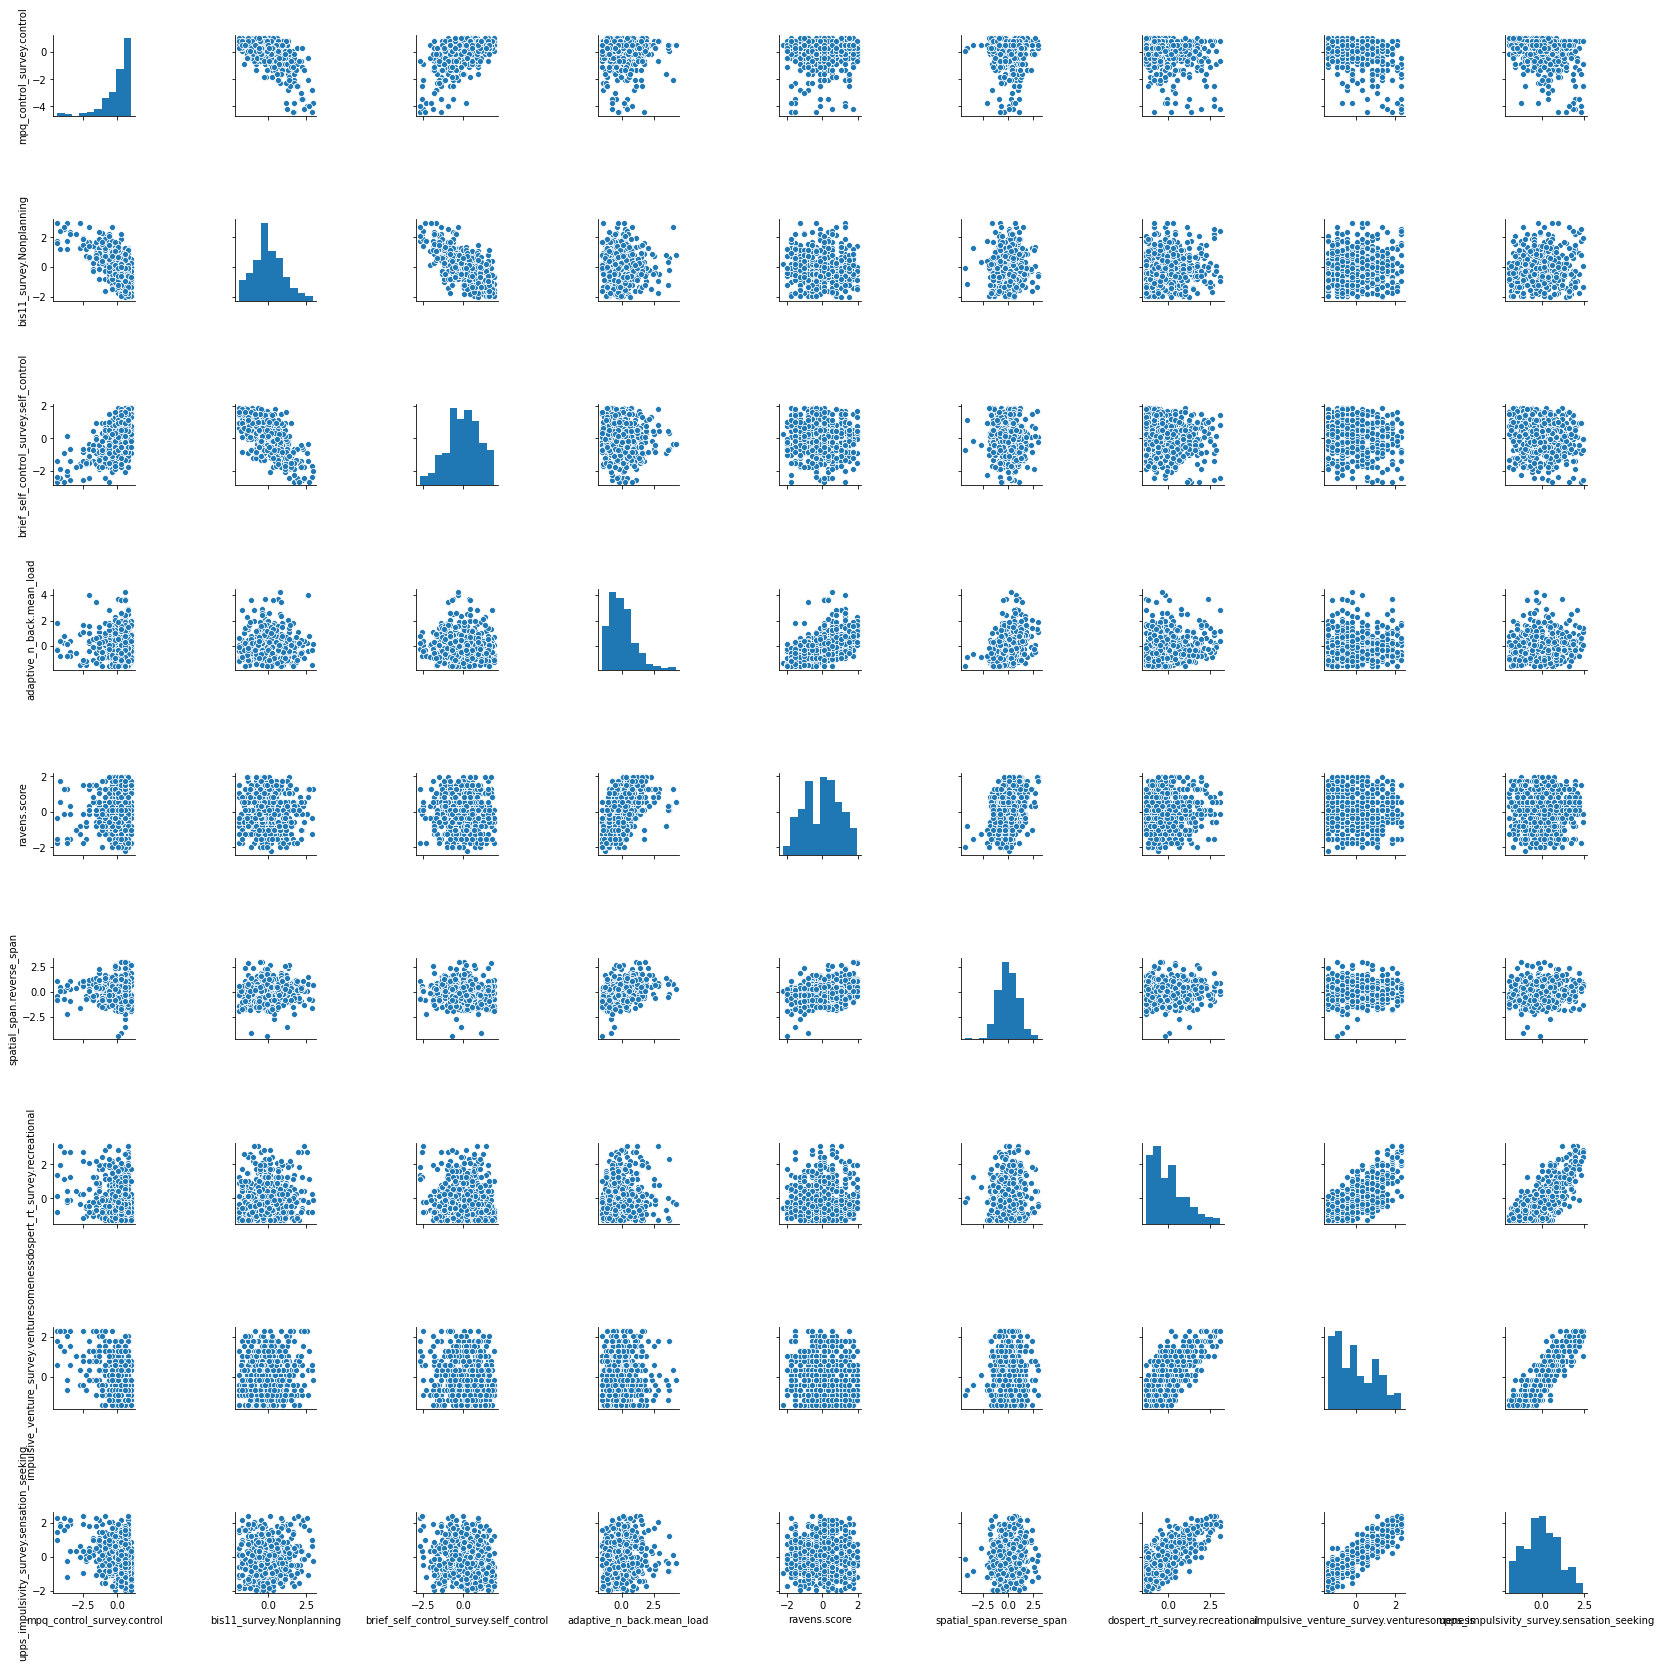

In [39]:
from data_utils import get_SRO_data
import scipy.stats

SRO_data = get_SRO_data()
cfadata = SRO_data[['mpq_control_survey.control',
                    'bis11_survey.Nonplanning',
                    'brief_self_control_survey.self_control',
                    'adaptive_n_back.mean_load',
                    'ravens.score',
                    'spatial_span.reverse_span',
                    'dospert_rt_survey.recreational',
                    'impulsive_venture_survey.venturesomeness',
                    'upps_impulsivity_survey.sensation_seeking']]
                    
                    
cfadata = cfadata.dropna()
# scale the data to make interpretation of covariances easier
cfadata = (cfadata - cfadata.mean(0))/cfadata.std(0)
sns.pairplot(cfadata)

In [40]:
%%R -i cfadata
# specify zero correlation between factors
cfa.model <- 'IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
'

fit <- cfa(cfa.model, data=cfadata)

summary(fit)

lavaan 0.6-5 ended normally after 28 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           504
                                                      
Model Test User Model:
                                                      
  Test statistic                                95.401
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  IMP =~                                              
    mpq_cntrl_srv.    1.000                           
    bs

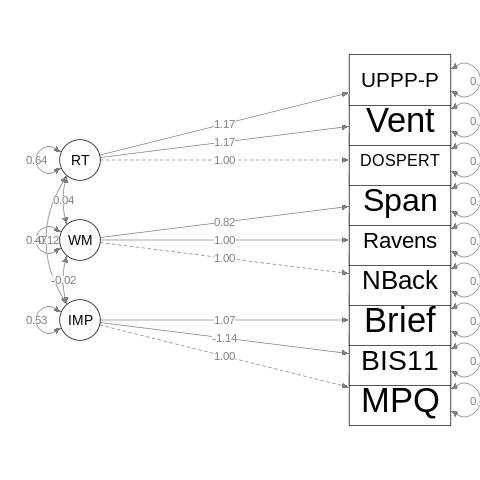

In [41]:
%%R

varnames = c('MPQ', 'BIS11', 'Brief', 'NBack', 'Ravens', 
             'Span', 'DOSPERT', 'Vent','UPPP-P', "IMP" ,"WM",  "RT" )

semPaths(fit, "model", "est", 
         rotation=2, sizeMan =20, sizeMan2 = 10, 
         nodeLabels=varnames, edge.label.cex = 1)

We can also compare the observed and implied covariance matrices:

Text(0.5, 1.0, 'implied covariance')

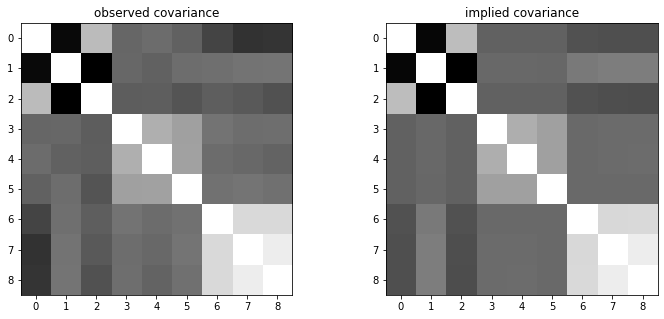

In [42]:
observed = cfadata.cov()
implied = r('fitted(fit)$cov')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(observed, interpolation='nearest', cmap='gray')
plt.title('observed covariance')
plt.subplot(1,2,2)
plt.imshow(implied, interpolation='nearest', cmap='gray')
plt.title('implied covariance')


Let's look a bit more closely at the matrices that go into generating the implied covariance matrix:

$$
\Sigma = \Lambda\Psi\Lambda' + \Theta
$$

where the $\Lambda$ matrix describes the mapping of measures to factors:



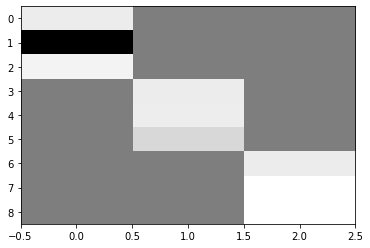

In [45]:
lmtx = r('inspect(fit,"est")$lambda')
plt.imshow(lmtx, aspect='auto', interpolation='nearest', cmap='gray')

The $\Phi$ matrix describes the variances and covariances of the latent factors:

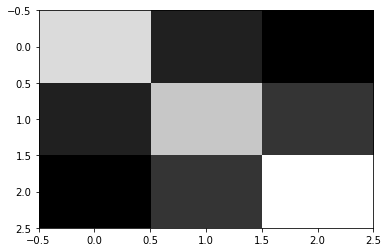

In [46]:
psimtx = r('inspect(fit,"est")$psi')
plt.imshow(psimtx, aspect='auto', interpolation='nearest', cmap='gray')

And the $\Theta$ matrix describes the error variance for the measurements:

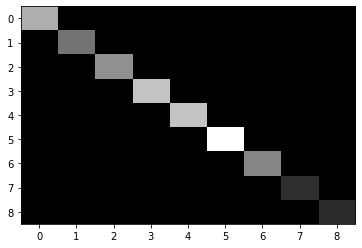

In [47]:
thetamtx = r('inspect(fit,"est")$theta')
plt.imshow(thetamtx, aspect='auto', interpolation='nearest', cmap='gray')

## Model fit testing

blah blah blah

In [43]:
%%R

summary(fit, fit.measures=TRUE)

lavaan 0.6-5 ended normally after 28 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           504
                                                      
Model Test User Model:
                                                      
  Test statistic                                95.401
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              2115.156
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.966
  Tucker-Lewis Index (TLI)                       0.948

Loglikelihood and Information Criteri

...


## Model comparison



In [15]:
%%R

# fit a simpler one-factor model
cfa.model2 <- 'F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
'

fit2 <- cfa(cfa.model2, data=cfadata)


In [16]:
%%R 

library(semTools)

compareFit(fit, fit2)

R[write to console]:  

R[write to console]: ###############################################################################

R[write to console]: This is semTools 0.5-2

R[write to console]: All users of R (or SEM) are invited to submit functions or ideas for functions.

R[write to console]: ###############################################################################



################### Nested Model Comparison #########################
Chi-Squared Difference Test

     Df   AIC   BIC   Chisq Chisq diff Df diff Pr(>Chisq)    
fit  24 14197 14286  95.401                                  
fit2 27 14929 15005 833.246     737.84       3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

####################### Model Fit Indices ###########################
        chisq df pvalue   cfi   tli        aic        bic rmsea  srmr
fit   95.401† 24   .000 .966† .948† 14197.191† 14285.866† .077† .055†
fit2 833.246  27   .000 .612  .483  14929.036  15005.042  .243  .186 

################## Differences in Fit Indices #######################
           df    cfi    tli     aic     bic rmsea  srmr
fit2 - fit  3 -0.353 -0.466 731.844 719.177 0.167 0.131



### Bifactor models

Sometimes there may be a general factor that encompasses a set of more specific factors. These kinds of data are often modeled using a specific form of CFA known as a *bifactor model*, in which there are both specific factors (associated with particular measurement variables) as well as a general factor associated with all measurement variables. Let's fit such a model to our data.

In [17]:
%%R -i cfadata

bifactor.model <- 'IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
            
               F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
                    
                                        
                F         ~~ 0*WM
                F         ~~ 0*IMP
                F         ~~ 0*RT

                    '

bifactor_fit <- cfa(bifactor.model, data=cfadata)

summary(bifactor_fit)

lavaan 0.6-5 ended normally after 108 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         30
                                                      
  Number of observations                           504
                                                      
Model Test User Model:
                                                      
  Test statistic                                29.126
  Degrees of freedom                                15
  P-value (Chi-square)                           0.015

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  IMP =~                                              
    mpq_cntrl_srv.    1.000                           
    b

In [18]:
%%R

summary(bifactor_fit, fit.measures=TRUE)

lavaan 0.6-5 ended normally after 108 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         30
                                                      
  Number of observations                           504
                                                      
Model Test User Model:
                                                      
  Test statistic                                29.126
  Degrees of freedom                                15
  P-value (Chi-square)                           0.015

Model Test Baseline Model:

  Test statistic                              2115.156
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.993
  Tucker-Lewis Index (TLI)                       0.984

Loglikelihood and Information Criter

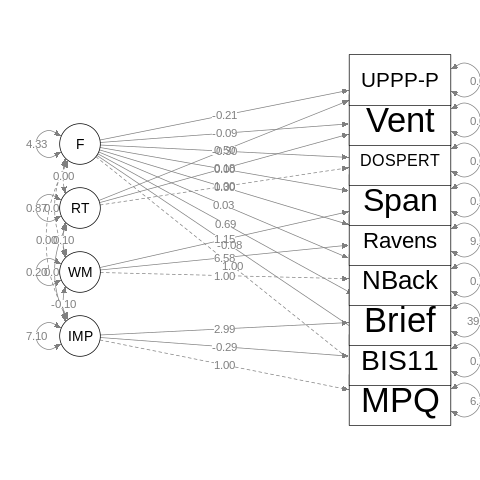

In [19]:
%%R
varnames = c('MPQ', 'BIS11', 'Brief', 'NBack', 'Ravens', 
             'Span', 'DOSPERT', 'Vent','UPPP-P', "IMP" ,"WM",  "RT", 'F' )

semPaths(bifactor_fit, "model", "est", 
         rotation=2, sizeMan =20, sizeMan2 = 10, 
         nodeLabels=varnames, edge.label.cex = 1)

In [20]:
%%R

compareFit(fit, bifactor_fit)

################### Nested Model Comparison #########################
Chi-Squared Difference Test

             Df   AIC   BIC  Chisq Chisq diff Df diff Pr(>Chisq)    
bifactor_fit 15 14149 14276 29.126                                  
fit          24 14197 14286 95.401     66.275       9  8.144e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

####################### Model Fit Indices ###########################
               chisq df pvalue   cfi   tli        aic        bic rmsea  srmr
bifactor_fit 29.126† 15   .015 .993† .984† 14148.916† 14275.593† .043† .018†
fit          95.401  24   .000 .966  .948  14197.191  14285.866  .077  .055 

################## Differences in Fit Indices #######################
                   df    cfi    tli    aic    bic rmsea  srmr
fit - bifactor_fit  9 -0.028 -0.035 48.275 10.272 0.034 0.037



We see that the model comparison suggests that the bifactor model is better.

## Cross-validation

We can also used cross-validation to assess the fit of a model to held-out data, using the same loss function that we used for fitting the model:


$$
F_{ML} = log |\Sigma(\theta)| + tr(\textbf{S}\Sigma^{-1}(\theta)) - log|\textbf{S}| - (p + q)
$$

To do this, let's create a python function that uses rpy2 to call lavaan:

In [21]:
def f_ml(cov_est, implied, verbose=False):
    log_det_implied = np.log(np.linalg.det(implied) )
    if verbose:
        print('log(det) for implied:', log_det_implied)
    cov_ratio_trace = np.trace(cov_est.dot(np.linalg.inv(implied)))
    if verbose:
        print('trace of variance ratios:', cov_ratio_trace)
    log_det_observed = np.log(np.linalg.det(cov_est))
    if verbose:
        print('log(det) for observed:', log_det_observed)
    F_ml = log_det_implied + cov_ratio_trace - log_det_observed - cov_est.shape[0]
    return(F_ml)


In [22]:

nruns = 10
test_proportion = .2

r('''
fml = function(observed, implied){
 log(det(implied)) - log(det(observed)) + sum(diag(observed%*%solve(implied))) + length(diag(observed))
}''')

fml = r('''
library(lavaan)

cfa.model <- "IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking"
                    
one_factor.model <- "F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking"

bifactor.model <- "IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
            
               F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
                    
                                        
                F         ~~ 0*WM
                F         ~~ 0*IMP
                F         ~~ 0*RT"

nruns = %d
testprop = %f
npts = nrow(cfadata)
idx = rep(0, npts)
idx[1:round(npts*testprop)] = 1
fmlresult = c()

for (i in 1:nruns){
    # split train/test
    idx = sample(idx)
    traindata = cfadata[idx==0,]
    testdata = cfadata[idx==1,]
    fit = cfa(cfa.model, data=traindata)
    fit2 = cfa(one_factor.model , data=traindata)
    fit3 = cfa(bifactor.model, data=traindata)


    test_cov = cov(testdata)
    train_cov = cov(traindata)
    implied_cov = fitted(fit)$cov
    fmlresult = rbind(fmlresult, c(fml(train_cov, fitted(fit)$cov), fml(train_cov, fitted(fit2)$cov), fml(train_cov, fitted(fit3)$cov),
            fml(test_cov, fitted(fit)$cov), fml(test_cov, fitted(fit2)$cov), fml(test_cov, fitted(fit3)$cov)))

}
''' % (nruns, test_proportion))



In [23]:
fmlresult = pd.DataFrame(r['fmlresult'].mean(0),
                        index=['Train:CFA', 'Train:1F', 'Train:Bifactor',
                              'Test:CFA', 'Test:1F', 'Test:Bifactor'])
fmlresult

,0
Train:CFA,18.194487
Train:1F,19.641183
Train:Bifactor,18.055994
Test:CFA,18.658812
Test:1F,20.185248
Test:Bifactor,18.576953


Crossvalidation confirms the results from model comparison: The bifactor model has slightly lower test error compared to the CFA model, both of which handily outperform the one-factor model.


## Estimating indirect effects: "mediation analysis"

It is common to estimate indirect effects, with the goal of understanding *causal mediation*. 
Note that there is a consensus amongst methodologists that causal mediation can only be truly assessed in situations where there is a clear causal relation between putative causes and effects, such as when there is time precedence between them.  This is not the case in many psychological studies, where the variables are assessed simultaneously and there is no experimental manipulation.  In his latest Klein states: "In general, the use of the term *mediation* should be reserved for designs that feature time precedence; otherwise, use of the term *indirect effect* is more realistic."

The model for indirect effects can be tested using SEM, which has advantages over the usual regression-based strategy: it is more flexible and also allows more appropriate handling of missing data.

Let's use SEM to determine whether there is an indirect effect of negative urgency on BMI, via emotion eating.

In [27]:
SRO_data['BMI'] = (SRO_data.WeightPounds / SRO_data.HeightInches**2) * 703
SRO_data = SRO_data.query('WeightPounds > 50 & BMI < 100')
mediation_data = SRO_data[['WeightPounds', 
                           'eating_survey.cognitive_restraint', 
                           'eating_survey.emotional_eating',
                          'upps_impulsivity_survey.negative_urgency',
                          'grit_scale_survey.grit', 'BMI', 'Depressed']]
# remove a few bad values
mediation_data = mediation_data.query('WeightPounds > 50 & BMI < 100')


Set up the SEM model:

In [25]:
%%R -i mediation_data
# https://m-clark.github.io/posts/2019-03-12-mediation-models/#lavaan
sem_model <- ' # regressions
             eating_survey.emotional_eating ~ a*upps_impulsivity_survey.negative_urgency
             BMI ~ c*upps_impulsivity_survey.negative_urgency + b*eating_survey.emotional_eating
             
              # direct effect
              direct := c

              # indirect effect
              indirect := a*b

              # total effect
              total := c + (a*b)
        
             # variances and covariances 
             BMI ~~ BMI 
             eating_survey.emotional_eating	 ~~ eating_survey.emotional_eating
             upps_impulsivity_survey.negative_urgency ~~ upps_impulsivity_survey.negative_urgency
            
             # intercepts 
             BMI ~ 1 
            upps_impulsivity_survey.negative_urgency ~ 1
            eating_survey.emotional_eating ~ 1
           '

 
model_sem = sem(sem_model, data=mediation_data, se='boot', bootstrap=500)
summary(model_sem, rsq=T)  # compare with ACME in mediation


lavaan 0.6-5 ended normally after 38 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          9
                                                      
  Number of observations                           518
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                            Bootstrap
  Number of requested bootstrap draws              500
  Number of successful bootstrap draws             500

Regressions:
                                   Estimate  Std.Err  z-value  P(>|z|)
  eating_survey.emotional_eating ~                                    
    upps_mp_._ (a)                   19.726    2.089    9.444    0.000
  BMI ~           

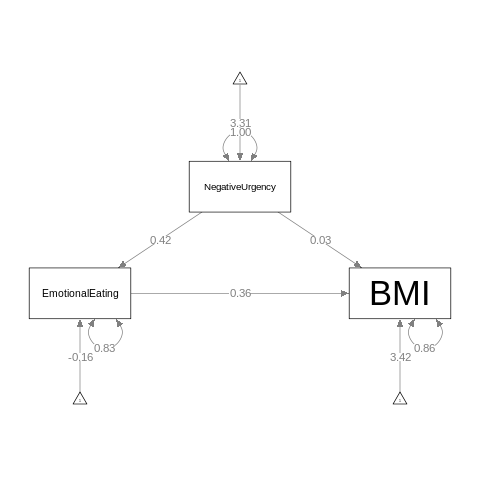

In [26]:
%%R

varnames = c('EmotionalEating', 'BMI', 'NegativeUrgency', '1', '1', '1')
semPaths(model_sem, "model", "std", 
         rotation=1,sizeMan =20, sizeMan2 = 10, 
         edge.label.cex = 1, layout='tree2', nodeLabels=varnames)

Here we see that the indirect effect is highly significant.  However, we should be cautious about interpreting this too strongly, as we will see in more detail in the following lecture